In [1]:
import sys
print(sys.executable)

d:\Program Files\python.exe


In [2]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))


TensorFlow version: 2.20.0
Num GPUs Available: 0


In [1]:
# Then import the required libraries
import importlib
import numpy as np
import os
import random

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
# Remove standalone keras imports and use tf.keras instead
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
# Update keras imports to use tf.keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
# Use tf.keras.models instead
from sklearn.model_selection import GridSearchCV
import joblib

In [2]:
seed = 0
np.random.seed(seed)

df = pd.read_csv('gene_level_methylation.csv')

print("Original columns:", df.columns.tolist()[:10], "...")

# Remove the "SingleValueType" column if it exists
if "SingleValueType" in df.columns:
    df = df.drop(columns=["SingleValueType"])
    print("Column 'SingleValueType' has been removed successfully.")
else:
    print("Column 'SingleValueType' does not exist in the DataFrame.")

# Sort columns and transpose
df = df.reindex(sorted(df.columns), axis=1)
df = df.T

# Set first row (originally "GeneSymbol") as new column names
df.columns = df.iloc[0]  # first row becomes column headers
df = df.drop(df.index[0])  # drop the first row

print("CNV Matrix After Transpose and Header Fix:", df.shape)
print("\nDataFrame preview:")
df.head()

Original columns: ['GeneSymbol', 'SingleValueType', 'TCGA-OL-A66H-01', 'TCGA-3C-AALK-01', 'TCGA-AC-A5EH-01', 'TCGA-EW-A2FW-01', 'TCGA-E9-A1R0-01', 'TCGA-AR-A1AJ-01', 'TCGA-AC-A62Y-01', 'TCGA-E9-A1QZ-01'] ...
Column 'SingleValueType' has been removed successfully.
CNV Matrix After Transpose and Header Fix: (888, 20141)

DataFrame preview:


GeneSymbol,RPS4Y2,TGIF2LY,RPS4Y1,TBL1Y,NLGN4Y,PRKY,PCDH11Y,FAM197Y2,TTTY20,TTTY15,...,MIR648,SOX10,C22orf28,NIPSNAP1,ENTHD1,APOL4,RIMBP3,UBE2L3,APOL5,C1QTNF6
TCGA-3C-AAAU-01,0.527,0.2106,0.439471,0.439471,0.18452,0.1233,0.103333,0.439471,0.439471,0.439471,...,0.86745,0.813967,0.641257,0.3118,0.6193,0.3352,0.9,0.439471,0.928,0.135
TCGA-3C-AALI-01,0.6489,0.4494,0.5074,0.461561,0.12094,0.8148,0.136333,0.456,0.461561,0.461561,...,0.91445,0.806833,0.510333,0.328633,0.7795,0.5119,0.9366,0.8098,0.8742,0.35
TCGA-3C-AALJ-01,0.6949,0.3483,0.483411,0.483411,0.09312,0.7933,0.103367,0.6686,0.483411,0.483411,...,0.87165,0.8028,0.545237,0.314633,0.9056,0.2498,0.9333,0.483411,0.8888,0.3422
TCGA-3C-AALK-01,0.49733,0.5494,0.5722,0.49733,0.40274,0.6853,0.224,0.6244,0.49733,0.49733,...,0.8761,0.7744,0.580743,0.320033,0.7763,0.3252,0.8661,0.3113,0.9321,0.2091
TCGA-4H-AAAK-01,0.4716,0.3791,0.473244,0.473244,0.2107,0.6571,0.357,0.4695,0.473244,0.473244,...,0.88625,0.792567,0.625633,0.320233,0.8337,0.4536,0.7104,0.2855,0.937,0.1767


In [5]:
df2=pd.read_csv('BRCA_clinicalMatrix.gz',compression='gzip',sep='\t',index_col=0)
df2.index = pd.Series({x: x.replace('-', '-') for x in df2.index})
print("Clinical Data Before:", df2.shape)
k=df2.columns.get_loc('PAM50Call_RNAseq')
df2=df2[df2.iloc[:,k].isna()==False]
df2.head()

Clinical Data Before: (1247, 202)


,AJCC_Stage_nature2012,Age_at_Initial_Pathologic_Diagnosis_nature2012,CN_Clusters_nature2012,Converted_Stage_nature2012,Days_to_Date_of_Last_Contact_nature2012,Days_to_date_of_Death_nature2012,ER_Status_nature2012,Gender_nature2012,HER2_Final_Status_nature2012,Integrated_Clusters_no_exp__nature2012,...,_GENOMIC_ID_TCGA_BRCA_mutation_wustl_gene,_GENOMIC_ID_TCGA_BRCA_miRNA_GA,_GENOMIC_ID_TCGA_BRCA_exp_HiSeqV2_percentile,_GENOMIC_ID_data/public/TCGA/BRCA/miRNA_GA_gene,_GENOMIC_ID_TCGA_BRCA_gistic2thd,_GENOMIC_ID_data/public/TCGA/BRCA/miRNA_HiSeq_gene,_GENOMIC_ID_TCGA_BRCA_G4502A_07_3,_GENOMIC_ID_TCGA_BRCA_exp_HiSeqV2,_GENOMIC_ID_TCGA_BRCA_gistic2,_GENOMIC_ID_TCGA_BRCA_PDMarray
TCGA-A1-A0SB-01,Stage I,70.0,1.0,Stage I,259.0,NaN,Positive,FEMALE,Negative,NaN,...,TCGA-A1-A0SB-01A-11D-A142-09,NaN,a2405d64-34eb-4915-abf7-8530151d5cb0,NaN,TCGA-A1-A0SB-01A-11D-A141-01,TCGA-A1-A0SB-01,NaN,a2405d64-34eb-4915-abf7-8530151d5cb0,TCGA-A1-A0SB-01A-11D-A141-01,NaN
TCGA-A1-A0SD-01,Stage IIA,59.0,2.0,Stage IIA,437.0,NaN,Positive,FEMALE,Negative,NaN,...,TCGA-A1-A0SD-01A-11D-A10Y-09,NaN,15bad71d-3031-413b-9e8d-6426ae5dfbea,NaN,TCGA-A1-A0SD-01A-11D-A111-01,TCGA-A1-A0SD-01,TCGA-A1-A0SD-01A-11R-A115-07,15bad71d-3031-413b-9e8d-6426ae5dfbea,TCGA-A1-A0SD-01A-11D-A111-01,TCGA-A1-A0SD-01
TCGA-A1-A0SE-01,Stage I,56.0,2.0,Stage I,1320.0,NaN,Positive,FEMALE,Negative,NaN,...,TCGA-A1-A0SE-01A-11D-A099-09,TCGA-A1-A0SE-01,a998e0ce-9248-460f-aabc-2dad452a1ff9,TCGA-A1-A0SE-01,TCGA-A1-A0SE-01A-11D-A087-01,NaN,TCGA-A1-A0SE-01A-11R-A084-07,a998e0ce-9248-460f-aabc-2dad452a1ff9,TCGA-A1-A0SE-01A-11D-A087-01,TCGA-A1-A0SE-01
TCGA-A1-A0SF-01,Stage IIA,54.0,3.0,Stage IIA,1463.0,NaN,Positive,FEMALE,Negative,NaN,...,TCGA-A1-A0SF-01A-11D-A142-09,NaN,28089e15-5e2c-4e83-ba6c-62b3cb40e431,NaN,TCGA-A1-A0SF-01A-11D-A141-01,TCGA-A1-A0SF-01,NaN,28089e15-5e2c-4e83-ba6c-62b3cb40e431,TCGA-A1-A0SF-01A-11D-A141-01,NaN
TCGA-A1-A0SG-01,Stage IIB,61.0,4.0,Stage IIB,433.0,NaN,Positive,FEMALE,Negative,NaN,...,TCGA-A1-A0SG-01A-11D-A142-09,NaN,0df6b948-367d-4951-9d98-d3bebabff63e,NaN,TCGA-A1-A0SG-01A-11D-A141-01,TCGA-A1-A0SG-01,NaN,0df6b948-367d-4951-9d98-d3bebabff63e,TCGA-A1-A0SG-01A-11D-A141-01,NaN


In [6]:
commonIndexes=np.sort(list(set(df2.index).intersection(set(df.index)))) 
df=df.loc[commonIndexes] 
df2=df2.loc[commonIndexes] 
print("Data After:", df.shape) 
print("Clinical Data After:", df2.shape) 
print("CNV and Clinical Data corresponds to same Patients: ", False if False in (df.index==df2.index) else True) 
unique_elements, counts_elements = np.unique(df2.iloc[:,k], return_counts=True) 
print("Labels", unique_elements, counts_elements)

Data After: (620, 20141)
Clinical Data After: (620, 202)
CNV and Clinical Data corresponds to same Patients:  True
Labels ['Basal' 'Her2' 'LumA' 'LumB' 'Normal'] [ 87  31 288 127  87]


In [7]:
#all genes

In [8]:
original_feature_names = df.columns.tolist()
X=np.array(df.values, dtype=float)
X.shape
Y=np.array(df2.values[:,k])
Y.shape

(620,)

In [9]:
from sklearn.model_selection import StratifiedKFold

n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)

In [10]:
folds = list(skf.split(X, Y))

# Select fold 4
train_idx, test_idx = folds[4]
X_train, X_test = X[train_idx], X[test_idx]
Y_train, Y_test = Y[train_idx], Y[test_idx]

X_train.shape, X_test.shape

((496, 20141), (124, 20141))

In [11]:
# Define features (X) and labels (y)
X = df.values.astype(float)    # features must be numeric
y = df2.iloc[:, k].values      # PAM50 labels
original_feature_names = df.columns.tolist()

print("Feature matrix shape:", X.shape)
print("Labels shape:", y.shape)
print("Classes:", np.unique(y))

Feature matrix shape: (620, 20141)
Labels shape: (620,)
Classes: ['Basal' 'Her2' 'LumA' 'LumB' 'Normal']


In [3]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.layers import LeakyReLU
from scikeras.wrappers import KerasClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from tensorflow.keras.optimizers import Adam
import time
import pandas as pd

# Split data FIRST
X_train = pd.read_csv("X_train.csv").values
X_test = pd.read_csv("X_test.csv").values
y_train = pd.read_csv("y_train.csv").values.ravel()
y_test = pd.read_csv("y_test.csv").values.ravel()

# Label encode
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# Get number of classes and input dimension
n_classes = len(np.unique(y_train_enc))
input_dim = X_train.shape[1]

print(f"Input dimensions: {input_dim}")
print(f"Number of classes: {n_classes}")

# Create function to build neural network with more options
def create_nn(meta, neurons_layer1=256, neurons_layer2=128, dropout_rate=0.3, 
              learning_rate=0.002, activation='relu', regularization=None):
    
    # Set regularizer
    if regularization == 'l1':
        reg = l1(1e-15)
    elif regularization == 'l2':
        reg = l2(1e-15)
    elif regularization == 'l1_l2':
        reg = l1_l2(l1=1e-15, l2=1e-15)
    else:
        reg = None

    # Get input dimensions from meta
    n_features_in = meta["n_features_in_"]
    n_classes = meta["n_classes_"]
    
    # Build model
    model = Sequential([
        Dense(neurons_layer1, activation=activation, kernel_regularizer=reg, 
              input_shape=(n_features_in,)),  # Adjust based on feature selection
        Dropout(dropout_rate),
        Dense(neurons_layer2, activation=activation, kernel_regularizer=reg),
        Dropout(dropout_rate),
        Dense(n_classes, activation='softmax')
    ])
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Wrap model
nn_model = KerasClassifier(
    model=create_nn, 
    epochs=100, 
    batch_size=16, 
    verbose=0,
    callbacks=[EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)]
)

# Pipeline with feature selection
pipeline = ImbPipeline([
    ('nn', nn_model)
])

# Parameter grid based on the paper
param_grid = {
    # Best from paper: None, ReLU, 0.002, 16, 0.3
    'nn__model__regularization': [None, 'l1', 'l2', 'l1_l2'],
    'nn__model__activation': ['relu', 'tanh', LeakyReLU(negative_slope=0.01)],
    'nn__model__learning_rate': [0.01, 0.002, 0.001, 0.0001, 0.00001, 0.000001],
    'nn__batch_size': [16, 32, 64, 128],
    'nn__model__dropout_rate': [0.1, 0.2, 0.3, 0.4, 0.5],
    #'nn__model__neurons_layer1': [128, 256],  # Not in paper but good to test
    #'nn__model__neurons_layer2': [64, 128]
}

# Use RandomizedSearchCV to sample combinations
print("Starting hyperparameter search...")
print(f"Total possible combinations: {4 * 3 * 6 * 4 * 5 * 2 * 2} = {4*3*6*4*5*2*2}")
print("Testing 50 random combinations with 3-fold CV = 150 model trainings\n")

start_time = time.time()

grid_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    n_iter=50,  # Test 50 random combinations
    cv=2,  # 3-fold CV (paper uses 5-fold, but 3 is faster)
    scoring='f1_weighted',
    n_jobs=1,  # Use 1 to avoid issues with Keras
    verbose=3,  # Maximum verbosity for progress tracking
    random_state=seed,
    return_train_score=True
)

# Fit with progress tracking
grid_search.fit(X_train, y_train_enc)

end_time = time.time()
elapsed_time = (end_time - start_time) / 60  # Convert to minutes

# Results
print("\n" + "="*80)
print("SEARCH COMPLETE!")
print("="*80)
print(f"\nTotal time: {elapsed_time:.2f} minutes")
print(f"\nBest parameters found:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nBest cross-validation accuracy: {grid_search.best_score_:.4f}")

# Test on held-out test set
test_acc = grid_search.score(X_test, y_test_enc)
print(f"Test set accuracy: {test_acc:.4f}")

# Create results dataframe
results_df = pd.DataFrame(grid_search.cv_results_)
results_df = results_df.sort_values('rank_test_score')

# Show top 10 configurations
print("\n" + "="*80)
print("TOP 10 CONFIGURATIONS:")
print("="*80)
top_10 = results_df[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']].head(10)
for idx, row in top_10.iterrows():
    print(f"\nRank {int(row['rank_test_score'])}:")
    print(f"  Accuracy: {row['mean_test_score']:.4f} (+/- {row['std_test_score']:.4f})")
    print(f"  Parameters: {row['params']}")

# Save results to CSV
results_df.to_csv('nn_hyperparameter_search_results.csv', index=False)
print("\n" + "="*80)
print("Full results saved to 'nn_hyperparameter_search_results.csv'")
print("="*80)

Input dimensions: 19277
Number of classes: 5
Starting hyperparameter search...
Total possible combinations: 5760 = 5760
Testing 50 random combinations with 3-fold CV = 150 model trainings

Fitting 2 folds for each of 50 candidates, totalling 100 fits


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=16, nn__model__activation=relu, nn__model__dropout_rate=0.2, nn__model__learning_rate=0.001, nn__model__regularization=l2;, score=(train=0.612, test=0.615) total time= 2.3min


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=16, nn__model__activation=relu, nn__model__dropout_rate=0.2, nn__model__learning_rate=0.001, nn__model__regularization=l2;, score=(train=0.739, test=0.689) total time= 1.9min


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=64, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate=0.5, nn__model__learning_rate=0.002, nn__model__regularization=l1;, score=(train=0.302, test=0.294) total time=  43.3s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=64, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate=0.5, nn__model__learning_rate=0.002, nn__model__regularization=l1;, score=(train=0.445, test=0.426) total time=  31.8s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=128, nn__model__activation=tanh, nn__model__dropout_rate=0.3, nn__model__learning_rate=0.001, nn__model__regularization=None;, score=(train=0.294, test=0.294) total time=  33.9s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=128, nn__model__activation=tanh, nn__model__dropout_rate=0.3, nn__model__learning_rate=0.001, nn__model__regularization=None;, score=(train=0.625, test=0.598) total time=  49.0s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=16, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate=0.4, nn__model__learning_rate=1e-06, nn__model__regularization=l1;, score=(train=0.532, test=0.436) total time= 5.2min


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=16, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate=0.4, nn__model__learning_rate=1e-06, nn__model__regularization=l1;, score=(train=0.490, test=0.474) total time= 4.1min


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=16, nn__model__activation=tanh, nn__model__dropout_rate=0.1, nn__model__learning_rate=1e-06, nn__model__regularization=l1;, score=(train=0.726, test=0.699) total time= 3.7min


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=16, nn__model__activation=tanh, nn__model__dropout_rate=0.1, nn__model__learning_rate=1e-06, nn__model__regularization=l1;, score=(train=0.757, test=0.695) total time= 3.7min


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=32, nn__model__activation=relu, nn__model__dropout_rate=0.1, nn__model__learning_rate=0.002, nn__model__regularization=None;, score=(train=0.793, test=0.764) total time=  32.4s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=32, nn__model__activation=relu, nn__model__dropout_rate=0.1, nn__model__learning_rate=0.002, nn__model__regularization=None;, score=(train=0.748, test=0.605) total time=  48.9s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=32, nn__model__activation=tanh, nn__model__dropout_rate=0.3, nn__model__learning_rate=1e-06, nn__model__regularization=None;, score=(train=0.653, test=0.583) total time= 1.5min


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=32, nn__model__activation=tanh, nn__model__dropout_rate=0.3, nn__model__learning_rate=1e-06, nn__model__regularization=None;, score=(train=0.637, test=0.592) total time= 1.6min


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=16, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate=0.2, nn__model__learning_rate=0.0001, nn__model__regularization=l2;, score=(train=0.927, test=0.770) total time= 3.6min


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=16, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate=0.2, nn__model__learning_rate=0.0001, nn__model__regularization=l2;, score=(train=0.972, test=0.776) total time= 4.0min


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=32, nn__model__activation=relu, nn__model__dropout_rate=0.5, nn__model__learning_rate=0.001, nn__model__regularization=l1_l2;, score=(train=0.294, test=0.294) total time=  46.6s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=32, nn__model__activation=relu, nn__model__dropout_rate=0.5, nn__model__learning_rate=0.001, nn__model__regularization=l1_l2;, score=(train=0.440, test=0.422) total time= 1.7min


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=128, nn__model__activation=relu, nn__model__dropout_rate=0.2, nn__model__learning_rate=1e-06, nn__model__regularization=l1_l2;, score=(train=0.294, test=0.294) total time=  38.0s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=128, nn__model__activation=relu, nn__model__dropout_rate=0.2, nn__model__learning_rate=1e-06, nn__model__regularization=l1_l2;, score=(train=0.294, test=0.294) total time=  33.6s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=32, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate=0.4, nn__model__learning_rate=0.002, nn__model__regularization=l1_l2;, score=(train=0.420, test=0.397) total time= 1.1min


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=32, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate=0.4, nn__model__learning_rate=0.002, nn__model__regularization=l1_l2;, score=(train=0.613, test=0.588) total time=  54.3s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=32, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate=0.2, nn__model__learning_rate=1e-05, nn__model__regularization=l2;, score=(train=0.870, test=0.755) total time= 1.9min


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=32, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate=0.2, nn__model__learning_rate=1e-05, nn__model__regularization=l2;, score=(train=0.877, test=0.723) total time= 2.0min


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=16, nn__model__activation=tanh, nn__model__dropout_rate=0.2, nn__model__learning_rate=0.001, nn__model__regularization=None;, score=(train=0.294, test=0.294) total time=  45.6s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=16, nn__model__activation=tanh, nn__model__dropout_rate=0.2, nn__model__learning_rate=0.001, nn__model__regularization=None;, score=(train=0.294, test=0.294) total time= 1.1min


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=32, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate=0.4, nn__model__learning_rate=0.0001, nn__model__regularization=l2;, score=(train=0.721, test=0.689) total time= 1.4min


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=32, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate=0.4, nn__model__learning_rate=0.0001, nn__model__regularization=l2;, score=(train=0.914, test=0.770) total time= 2.7min


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=128, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate=0.3, nn__model__learning_rate=0.0001, nn__model__regularization=None;, score=(train=0.884, test=0.767) total time=  59.0s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=128, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate=0.3, nn__model__learning_rate=0.0001, nn__model__regularization=None;, score=(train=0.916, test=0.744) total time= 1.3min


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=16, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate=0.2, nn__model__learning_rate=0.002, nn__model__regularization=None;, score=(train=0.836, test=0.778) total time= 1.2min


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=16, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate=0.2, nn__model__learning_rate=0.002, nn__model__regularization=None;, score=(train=0.882, test=0.753) total time= 1.8min


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=32, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate=0.5, nn__model__learning_rate=1e-06, nn__model__regularization=None;, score=(train=0.294, test=0.294) total time= 1.5min


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=32, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate=0.5, nn__model__learning_rate=1e-06, nn__model__regularization=None;, score=(train=0.294, test=0.294) total time=  48.4s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=64, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate=0.2, nn__model__learning_rate=0.01, nn__model__regularization=None;, score=(train=0.782, test=0.734) total time= 1.1min


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=64, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate=0.2, nn__model__learning_rate=0.01, nn__model__regularization=None;, score=(train=0.560, test=0.520) total time=  29.6s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=64, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate=0.3, nn__model__learning_rate=0.002, nn__model__regularization=l2;, score=(train=0.781, test=0.752) total time=  33.7s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=64, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate=0.3, nn__model__learning_rate=0.002, nn__model__regularization=l2;, score=(train=0.620, test=0.654) total time=  33.2s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=128, nn__model__activation=tanh, nn__model__dropout_rate=0.5, nn__model__learning_rate=0.01, nn__model__regularization=l1;, score=(train=0.294, test=0.294) total time=  25.5s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=128, nn__model__activation=tanh, nn__model__dropout_rate=0.5, nn__model__learning_rate=0.01, nn__model__regularization=l1;, score=(train=0.294, test=0.294) total time=  24.1s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=16, nn__model__activation=tanh, nn__model__dropout_rate=0.3, nn__model__learning_rate=0.0001, nn__model__regularization=l2;, score=(train=0.809, test=0.703) total time= 2.8min


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=16, nn__model__activation=tanh, nn__model__dropout_rate=0.3, nn__model__learning_rate=0.0001, nn__model__regularization=l2;, score=(train=0.976, test=0.803) total time= 4.6min


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=16, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate=0.1, nn__model__learning_rate=0.0001, nn__model__regularization=l2;, score=(train=0.996, test=0.783) total time= 4.0min


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=16, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate=0.1, nn__model__learning_rate=0.0001, nn__model__regularization=l2;, score=(train=0.992, test=0.787) total time= 3.6min


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=32, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate=0.3, nn__model__learning_rate=0.01, nn__model__regularization=l1_l2;, score=(train=0.660, test=0.607) total time= 2.0min


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=32, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate=0.3, nn__model__learning_rate=0.01, nn__model__regularization=l1_l2;, score=(train=0.451, test=0.436) total time= 1.2min


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=128, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate=0.5, nn__model__learning_rate=0.002, nn__model__regularization=l1;, score=(train=0.670, test=0.631) total time=  58.4s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=128, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate=0.5, nn__model__learning_rate=0.002, nn__model__regularization=l1;, score=(train=0.598, test=0.561) total time=  54.6s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=128, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate=0.4, nn__model__learning_rate=1e-05, nn__model__regularization=l1;, score=(train=0.750, test=0.730) total time= 1.0min


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=128, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate=0.4, nn__model__learning_rate=1e-05, nn__model__regularization=l1;, score=(train=0.558, test=0.507) total time=  43.0s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=64, nn__model__activation=tanh, nn__model__dropout_rate=0.1, nn__model__learning_rate=0.0001, nn__model__regularization=l1;, score=(train=0.984, test=0.781) total time= 1.4min


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=64, nn__model__activation=tanh, nn__model__dropout_rate=0.1, nn__model__learning_rate=0.0001, nn__model__regularization=l1;, score=(train=0.984, test=0.797) total time= 1.2min


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=16, nn__model__activation=tanh, nn__model__dropout_rate=0.1, nn__model__learning_rate=1e-06, nn__model__regularization=l2;, score=(train=0.711, test=0.686) total time= 3.4min


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=16, nn__model__activation=tanh, nn__model__dropout_rate=0.1, nn__model__learning_rate=1e-06, nn__model__regularization=l2;, score=(train=0.752, test=0.685) total time= 3.6min


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=16, nn__model__activation=tanh, nn__model__dropout_rate=0.5, nn__model__learning_rate=0.001, nn__model__regularization=None;, score=(train=0.294, test=0.294) total time= 2.3min


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=16, nn__model__activation=tanh, nn__model__dropout_rate=0.5, nn__model__learning_rate=0.001, nn__model__regularization=None;, score=(train=0.294, test=0.294) total time= 1.7min


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=64, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate=0.4, nn__model__learning_rate=1e-06, nn__model__regularization=l2;, score=(train=0.294, test=0.294) total time=  24.1s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=64, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate=0.4, nn__model__learning_rate=1e-06, nn__model__regularization=l2;, score=(train=0.294, test=0.294) total time=  25.1s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=16, nn__model__activation=tanh, nn__model__dropout_rate=0.5, nn__model__learning_rate=0.002, nn__model__regularization=l1_l2;, score=(train=0.294, test=0.294) total time= 1.8min


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=16, nn__model__activation=tanh, nn__model__dropout_rate=0.5, nn__model__learning_rate=0.002, nn__model__regularization=l1_l2;, score=(train=0.294, test=0.294) total time= 3.3min


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=16, nn__model__activation=relu, nn__model__dropout_rate=0.2, nn__model__learning_rate=0.002, nn__model__regularization=l1_l2;, score=(train=0.523, test=0.498) total time= 1.3min


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=16, nn__model__activation=relu, nn__model__dropout_rate=0.2, nn__model__learning_rate=0.002, nn__model__regularization=l1_l2;, score=(train=0.656, test=0.641) total time= 2.9min


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=16, nn__model__activation=tanh, nn__model__dropout_rate=0.4, nn__model__learning_rate=0.001, nn__model__regularization=l2;, score=(train=0.294, test=0.294) total time= 1.8min


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=16, nn__model__activation=tanh, nn__model__dropout_rate=0.4, nn__model__learning_rate=0.001, nn__model__regularization=l2;, score=(train=0.294, test=0.294) total time=  52.7s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=64, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate=0.3, nn__model__learning_rate=1e-05, nn__model__regularization=l2;, score=(train=0.781, test=0.742) total time= 1.3min


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=64, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate=0.3, nn__model__learning_rate=1e-05, nn__model__regularization=l2;, score=(train=0.784, test=0.692) total time= 1.4min


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=16, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate=0.3, nn__model__learning_rate=0.001, nn__model__regularization=l1_l2;, score=(train=0.602, test=0.608) total time= 1.5min


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=16, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate=0.3, nn__model__learning_rate=0.001, nn__model__regularization=l1_l2;, score=(train=0.649, test=0.591) total time= 1.7min


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=64, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate=0.5, nn__model__learning_rate=0.01, nn__model__regularization=l2;, score=(train=0.294, test=0.294) total time=  37.7s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=64, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate=0.5, nn__model__learning_rate=0.01, nn__model__regularization=l2;, score=(train=0.517, test=0.477) total time=  48.2s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=32, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate=0.5, nn__model__learning_rate=1e-05, nn__model__regularization=l1;, score=(train=0.719, test=0.654) total time= 2.3min


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=32, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate=0.5, nn__model__learning_rate=1e-05, nn__model__regularization=l1;, score=(train=0.636, test=0.611) total time= 1.7min


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=128, nn__model__activation=relu, nn__model__dropout_rate=0.2, nn__model__learning_rate=0.0001, nn__model__regularization=None;, score=(train=0.923, test=0.783) total time=  50.5s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=128, nn__model__activation=relu, nn__model__dropout_rate=0.2, nn__model__learning_rate=0.0001, nn__model__regularization=None;, score=(train=0.912, test=0.741) total time=  52.0s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=64, nn__model__activation=relu, nn__model__dropout_rate=0.5, nn__model__learning_rate=1e-06, nn__model__regularization=l2;, score=(train=0.294, test=0.294) total time=  31.4s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=64, nn__model__activation=relu, nn__model__dropout_rate=0.5, nn__model__learning_rate=1e-06, nn__model__regularization=l2;, score=(train=0.294, test=0.294) total time=  30.6s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=16, nn__model__activation=relu, nn__model__dropout_rate=0.5, nn__model__learning_rate=0.001, nn__model__regularization=l1_l2;, score=(train=0.294, test=0.294) total time= 2.1min


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=16, nn__model__activation=relu, nn__model__dropout_rate=0.5, nn__model__learning_rate=0.001, nn__model__regularization=l1_l2;, score=(train=0.294, test=0.294) total time= 1.8min


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=32, nn__model__activation=relu, nn__model__dropout_rate=0.5, nn__model__learning_rate=1e-06, nn__model__regularization=l1;, score=(train=0.294, test=0.294) total time= 1.4min


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=32, nn__model__activation=relu, nn__model__dropout_rate=0.5, nn__model__learning_rate=1e-06, nn__model__regularization=l1;, score=(train=0.294, test=0.294) total time=  36.8s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=16, nn__model__activation=relu, nn__model__dropout_rate=0.1, nn__model__learning_rate=0.002, nn__model__regularization=None;, score=(train=0.722, test=0.658) total time=  55.9s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=16, nn__model__activation=relu, nn__model__dropout_rate=0.1, nn__model__learning_rate=0.002, nn__model__regularization=None;, score=(train=0.802, test=0.749) total time= 1.2min


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=16, nn__model__activation=relu, nn__model__dropout_rate=0.3, nn__model__learning_rate=0.002, nn__model__regularization=None;, score=(train=0.455, test=0.439) total time= 1.0min


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=16, nn__model__activation=relu, nn__model__dropout_rate=0.3, nn__model__learning_rate=0.002, nn__model__regularization=None;, score=(train=0.294, test=0.294) total time= 1.2min


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=16, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate=0.2, nn__model__learning_rate=0.0001, nn__model__regularization=l1_l2;, score=(train=0.972, test=0.802) total time= 4.9min


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=16, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate=0.2, nn__model__learning_rate=0.0001, nn__model__regularization=l1_l2;, score=(train=0.951, test=0.796) total time= 4.1min


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=16, nn__model__activation=relu, nn__model__dropout_rate=0.3, nn__model__learning_rate=0.002, nn__model__regularization=l2;, score=(train=0.583, test=0.591) total time=  55.7s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=16, nn__model__activation=relu, nn__model__dropout_rate=0.3, nn__model__learning_rate=0.002, nn__model__regularization=l2;, score=(train=0.617, test=0.606) total time=  36.6s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=64, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate=0.4, nn__model__learning_rate=0.002, nn__model__regularization=l1_l2;, score=(train=0.721, test=0.702) total time=  31.5s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=64, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate=0.4, nn__model__learning_rate=0.002, nn__model__regularization=l1_l2;, score=(train=0.748, test=0.691) total time=  43.9s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=128, nn__model__activation=relu, nn__model__dropout_rate=0.1, nn__model__learning_rate=0.0001, nn__model__regularization=l1_l2;, score=(train=0.935, test=0.781) total time=  49.7s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=128, nn__model__activation=relu, nn__model__dropout_rate=0.1, nn__model__learning_rate=0.0001, nn__model__regularization=l1_l2;, score=(train=0.947, test=0.782) total time=  50.5s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=16, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate=0.1, nn__model__learning_rate=0.0001, nn__model__regularization=l1;, score=(train=0.984, test=0.792) total time= 2.7min


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=16, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate=0.1, nn__model__learning_rate=0.0001, nn__model__regularization=l1;, score=(train=0.976, test=0.794) total time= 3.5min


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=128, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate=0.1, nn__model__learning_rate=0.0001, nn__model__regularization=l1_l2;, score=(train=0.956, test=0.789) total time= 1.1min


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=128, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate=0.1, nn__model__learning_rate=0.0001, nn__model__regularization=l1_l2;, score=(train=0.960, test=0.775) total time= 1.2min


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=64, nn__model__activation=relu, nn__model__dropout_rate=0.1, nn__model__learning_rate=1e-06, nn__model__regularization=l2;, score=(train=0.311, test=0.303) total time=  50.8s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=64, nn__model__activation=relu, nn__model__dropout_rate=0.1, nn__model__learning_rate=1e-06, nn__model__regularization=l2;, score=(train=0.302, test=0.294) total time= 1.5min


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=64, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate=0.1, nn__model__learning_rate=0.001, nn__model__regularization=l1_l2;, score=(train=0.899, test=0.791) total time=  54.5s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=64, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate=0.1, nn__model__learning_rate=0.001, nn__model__regularization=l1_l2;, score=(train=0.972, test=0.794) total time= 1.3min


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



SEARCH COMPLETE!

Total time: 170.63 minutes

Best parameters found:
  nn__model__regularization: l1_l2
  nn__model__learning_rate: 0.0001
  nn__model__dropout_rate: 0.2
  nn__model__activation: <LeakyReLU name=leaky_re_lu, built=True>
  nn__batch_size: 16

Best cross-validation accuracy: 0.7989
Test set accuracy: 0.7944

TOP 10 CONFIGURATIONS:

Rank 1:
  Accuracy: 0.7989 (+/- 0.0028)
  Parameters: {'nn__model__regularization': 'l1_l2', 'nn__model__learning_rate': 0.0001, 'nn__model__dropout_rate': 0.2, 'nn__model__activation': <LeakyReLU name=leaky_re_lu, built=True>, 'nn__batch_size': 16}

Rank 2:
  Accuracy: 0.7932 (+/- 0.0009)
  Parameters: {'nn__model__regularization': 'l1', 'nn__model__learning_rate': 0.0001, 'nn__model__dropout_rate': 0.1, 'nn__model__activation': <LeakyReLU name=leaky_re_lu, built=True>, 'nn__batch_size': 16}

Rank 3:
  Accuracy: 0.7927 (+/- 0.0013)
  Parameters: {'nn__model__regularization': 'l1_l2', 'nn__model__learning_rate': 0.001, 'nn__model__dropout_rate


Test Accuracy (Best Neural Network): 0.7944

Classification Report (Best Neural Network):
              precision    recall  f1-score   support

       Basal       0.94      0.94      0.94        17
        Her2       0.71      0.71      0.71         7
        LumA       0.81      0.83      0.82        58
        LumB       0.67      0.56      0.61        25
      Normal       0.80      0.94      0.86        17

    accuracy                           0.80       124
   macro avg       0.79      0.80      0.79       124
weighted avg       0.79      0.80      0.79       124



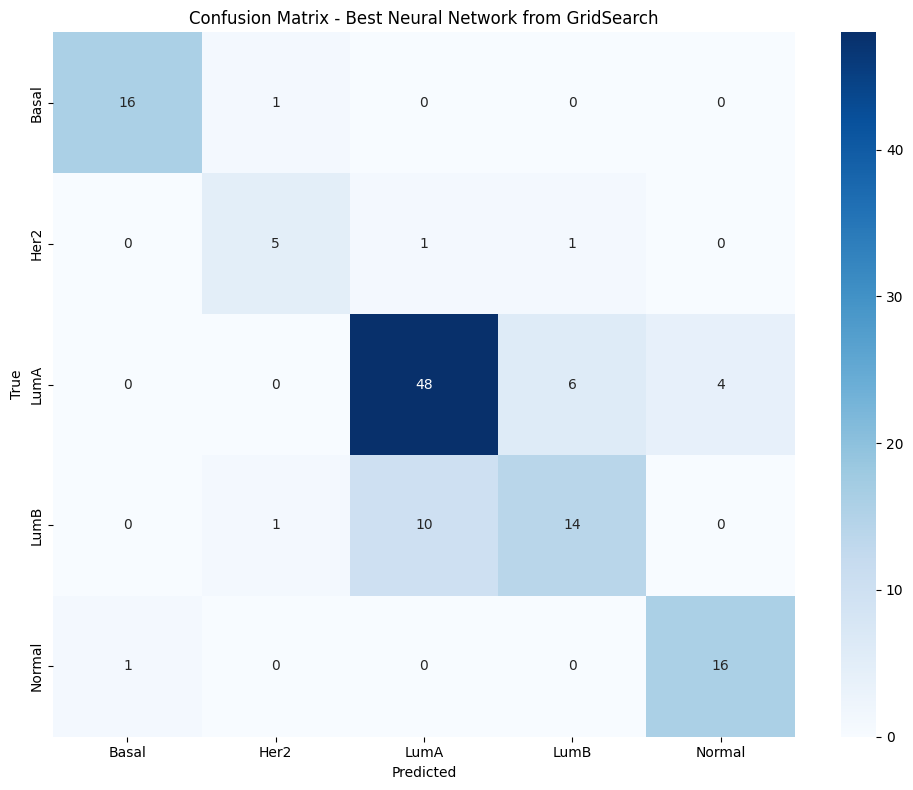


Retraining best model to visualize training history...


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


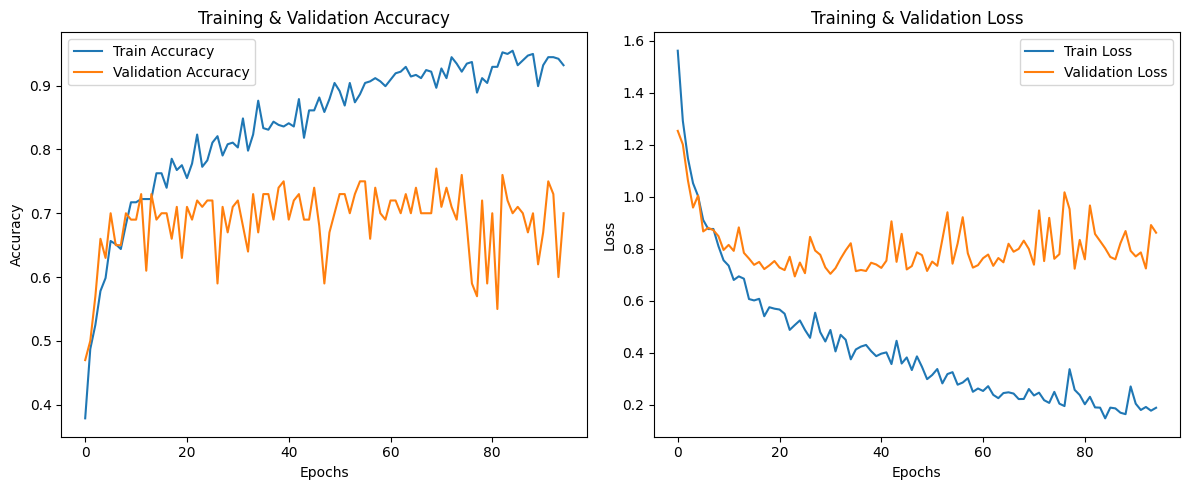

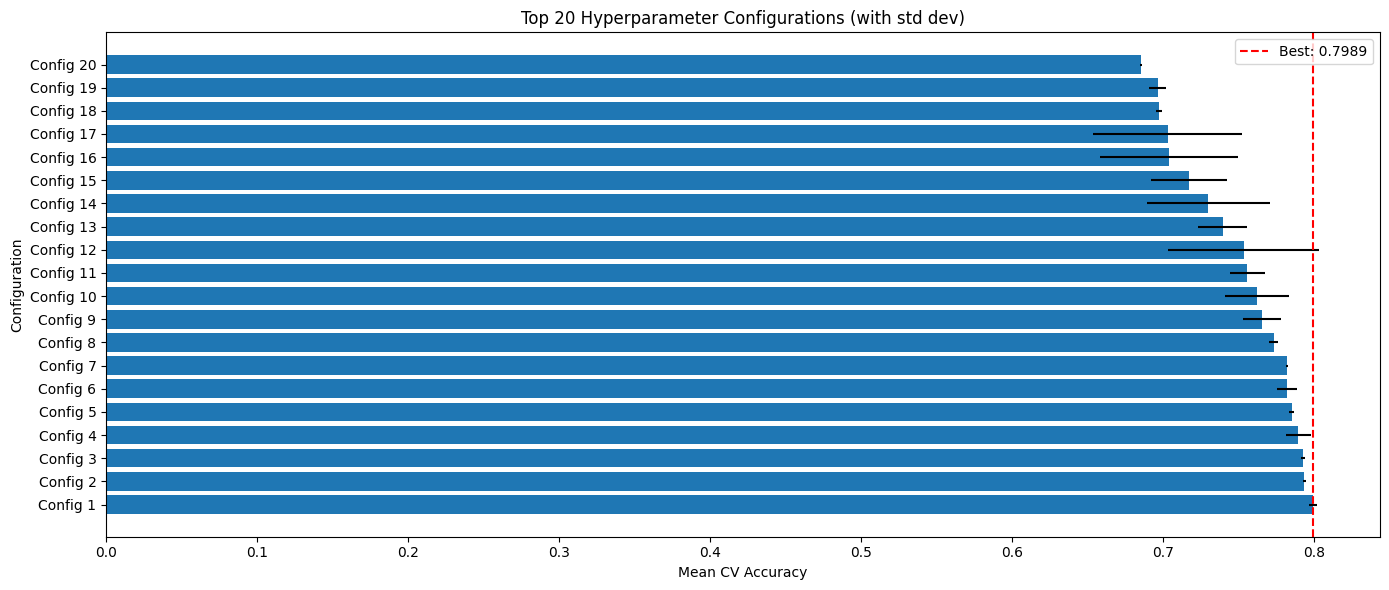

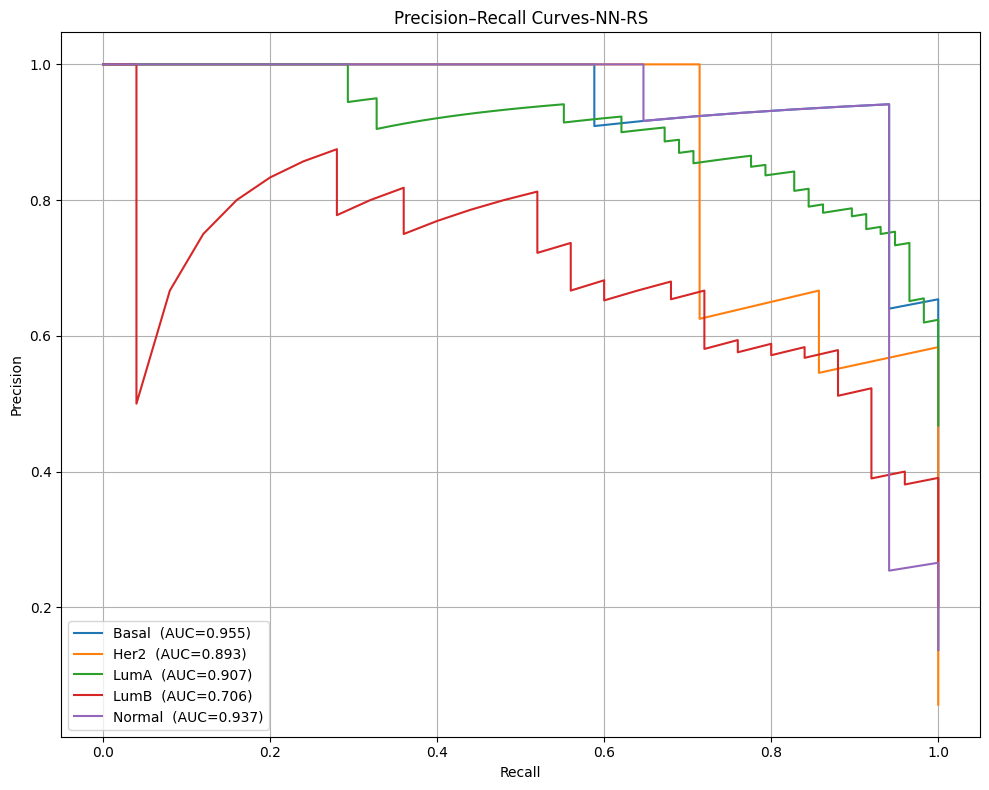


HYPERPARAMETER ANALYSIS:

nn__model__regularization:
  l1_l2: appears 4/10 times in top 10
  l1: appears 2/10 times in top 10
  l2: appears 2/10 times in top 10
  None: appears 2/10 times in top 10

nn__model__activation:
  <LeakyReLU name=leaky_re_lu, built=True>: appears 7/10 times in top 10
  relu: appears 2/10 times in top 10
  tanh: appears 1/10 times in top 10

nn__model__learning_rate:
  0.0001: appears 8/10 times in top 10
  0.001: appears 1/10 times in top 10
  0.002: appears 1/10 times in top 10

nn__batch_size:
  16: appears 5/10 times in top 10
  128: appears 3/10 times in top 10
  64: appears 2/10 times in top 10

nn__model__dropout_rate:
  0.1: appears 6/10 times in top 10
  0.2: appears 4/10 times in top 10


D:\TEMP\ipykernel_19696\3381488541.py:166: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(cv_scores, labels=[f'Fold {i+1}' for i in range(n_folds)])


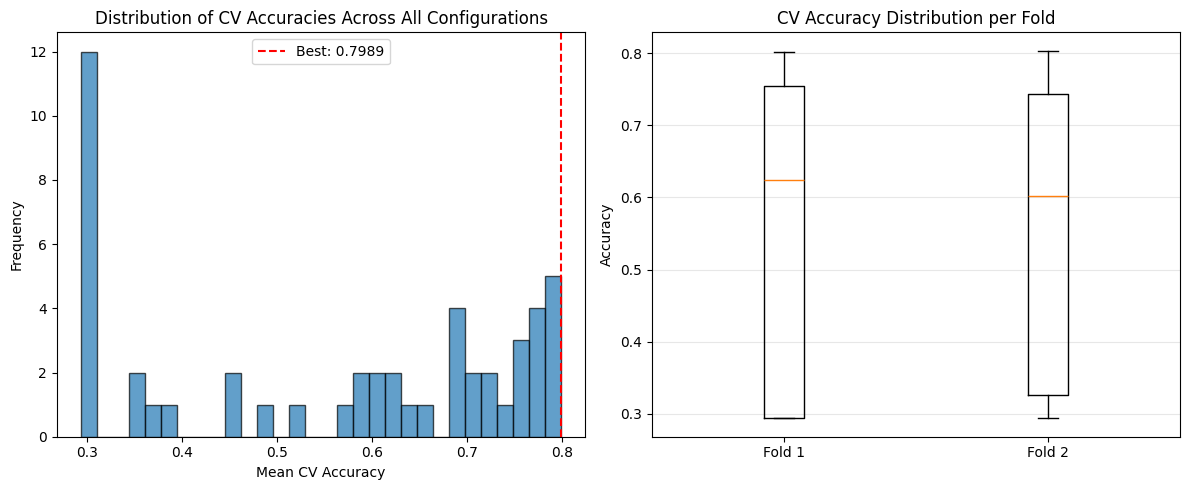


SUMMARY STATISTICS:
Best CV Accuracy: 0.7989
Test Accuracy: 0.7944
Mean CV Accuracy (all configs): 0.5616
Std CV Accuracy (all configs): 0.1927
Min CV Accuracy: 0.2938
Max CV Accuracy: 0.7989


In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve ,average_precision_score
from sklearn.preprocessing import label_binarize
import pandas as pd
from collections import Counter

# Evaluate on test set using best model from grid search
test_acc = grid_search.score(X_test, y_test_enc)
print(f"\nTest Accuracy (Best Neural Network): {test_acc:.4f}")

# Predict using best model
y_pred_classes = grid_search.predict(X_test)
y_pred_proba = grid_search.predict_proba(X_test)

# Classification report
print("\nClassification Report (Best Neural Network):")
print(classification_report(y_test_enc, y_pred_classes, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(y_test_enc, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Best Neural Network from GridSearch')
plt.tight_layout()
plt.show()

print("\nRetraining best model to visualize training history...")

best_params = grid_search.best_params_

meta = {
    "n_features_in_": X_train.shape[1],
    "n_classes_": len(np.unique(y_train_enc))
}

best_model = create_nn(
    meta=meta,
    neurons_layer1=best_params.get('nn__model__neurons_layer1', 256),
    neurons_layer2=best_params.get('nn__model__neurons_layer2', 128),
    dropout_rate=best_params['nn__model__dropout_rate'],
    learning_rate=best_params['nn__model__learning_rate'],
    activation=best_params['nn__model__activation'],
    regularization=best_params['nn__model__regularization']
)

history = best_model.fit(
    X_train, y_train_enc,
    validation_split=0.2,
    epochs=100,
    batch_size=best_params['nn__batch_size'],
    verbose=0,
    callbacks=[EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)]
)

# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# ------------------------------------------------------------------
# GridSearch Results Visualization
# ------------------------------------------------------------------

results_df = pd.DataFrame(grid_search.cv_results_)

# Plot top 20 configurations
plt.figure(figsize=(14, 6))
top_20 = results_df.nsmallest(20, 'rank_test_score')

plt.barh(range(len(top_20)), top_20['mean_test_score'], xerr=top_20['std_test_score'])
plt.yticks(range(len(top_20)), [f"Config {i+1}" for i in range(len(top_20))])
plt.xlabel('Mean CV Accuracy')
plt.ylabel('Configuration')
plt.title('Top 20 Hyperparameter Configurations (with std dev)')
plt.axvline(x=grid_search.best_score_, color='r', linestyle='--', label=f'Best: {grid_search.best_score_:.4f}')
plt.legend()
plt.tight_layout()
plt.show()

# PRECISION–RECALL CURVE
# -------------------------------
# Convert predictions into the max probability for each sample
y_score = np.max(y_pred_proba, axis=1)

# Convert true labels to 1 if correct, 0 otherwise
y_test_binarized = label_binarize(y_test_enc, classes=range(len(le.classes_)))

plt.figure(figsize=(10, 8))


for i, class_name in enumerate(le.classes_):
    precision, recall, _ = precision_recall_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    auc_score = average_precision_score(y_test_binarized[:, i], y_pred_proba[:, i])
    plt.plot(recall, precision, label=f"{class_name}  (AUC={auc_score:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves-NN-RS")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
# ------------------------------------------------------------------
# Hyperparameter importance analysis
# ------------------------------------------------------------------

print("\n" + "="*80)
print("HYPERPARAMETER ANALYSIS:")
print("="*80)

top_10_configs = results_df.nsmallest(10, 'rank_test_score')

for param in ['nn__model__regularization', 'nn__model__activation', 
              'nn__model__learning_rate', 'nn__batch_size', 'nn__model__dropout_rate']:
    print(f"\n{param}:")
    param_values = [config[param] for config in top_10_configs['params']]
    counts = Counter(param_values)
    for value, count in counts.most_common():
        print(f"  {value}: appears {count}/10 times in top 10")

# ------------------------------------------------------------------
# CV Accuracy Distribution
# ------------------------------------------------------------------

plt.figure(figsize=(12, 5))

# Histogram of all CV accuracies
plt.subplot(1, 2, 1)
plt.hist(results_df['mean_test_score'], bins=30, edgecolor='black', alpha=0.7)
plt.axvline(x=grid_search.best_score_, color='r', linestyle='--', 
            label=f'Best: {grid_search.best_score_:.4f}')
plt.xlabel('Mean CV Accuracy')
plt.ylabel('Frequency')
plt.title('Distribution of CV Accuracies Across All Configurations')
plt.legend()

# Box plot (adjust to number of folds)
plt.subplot(1, 2, 2)
n_folds = grid_search.cv  # dynamically use actual folds
cv_scores = [results_df[f'split{i}_test_score'] for i in range(n_folds)]
plt.boxplot(cv_scores, labels=[f'Fold {i+1}' for i in range(n_folds)])
plt.ylabel('Accuracy')
plt.title('CV Accuracy Distribution per Fold')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# ------------------------------------------------------------------
# Summary statistics
# ------------------------------------------------------------------

print("\n" + "="*80)
print("SUMMARY STATISTICS:")
print("="*80)
print(f"Best CV Accuracy: {grid_search.best_score_:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Mean CV Accuracy (all configs): {results_df['mean_test_score'].mean():.4f}")
print(f"Std CV Accuracy (all configs): {results_df['mean_test_score'].std():.4f}")
print(f"Min CV Accuracy: {results_df['mean_test_score'].min():.4f}")
print(f"Max CV Accuracy: {results_df['mean_test_score'].max():.4f}")


In [ ]:
import shap
import lime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# ==========================================
# SETTINGS
# ==========================================
MAX_BACKGROUND = 10
MAX_EXPLAIN = 50
SHAP_BATCH_SIZE = 32
RANDOM_STATE = 42
TOP_K = 10

OUT_DIR = "./explain_results"
os.makedirs(OUT_DIR, exist_ok=True)

# ==========================================
# EXTRACT BEST KERAS MODEL FROM HYPERPARAM SEARCH
# ==========================================
# Example: grid_search is your sklearn/Scikeras search object
# It should have attribute best_estimator_
best_model = grid_search.best_estimator_

# If it's a Scikeras wrapper, extract the underlying Keras model
keras_model = getattr(best_model, "model_", None)
if keras_model is None:
    try:
        keras_model = best_model.named_steps['nn'].model_
    except Exception:
        keras_model = best_model  # fallback: raw Keras model

print("Using Keras model from hyperparameter search:", type(keras_model))

# ==========================================
# WRAPPER FOR REDUCED FEATURES
# ==========================================
X_mean = X_train_arr.mean(axis=0)

def model_wrapper(X_reduced):
    """Map reduced features back to full model input for Keras."""
    X_full = np.tile(X_mean, (X_reduced.shape[0], 1))
    X_full[:, keep_idx] = X_reduced
    return keras_model.predict(X_full)

# ==========================================
# SHAP EXPLANATIONS
# ==========================================
print("\n[SHAP] Generating explanations...")

small_bg = shap.sample(X_train_reduced, min(MAX_BACKGROUND, X_train_reduced.shape[0]), random_state=RANDOM_STATE)
small_test = shap.sample(X_test_reduced, min(MAX_EXPLAIN, X_test_reduced.shape[0]), random_state=RANDOM_STATE)

# Attempt DeepExplainer first
try:
    explainer = shap.DeepExplainer(keras_model, small_bg)
    use_wrapper = False
    print("Using DeepExplainer for Keras model.")
except Exception:
    explainer = shap.Explainer(model_wrapper, small_bg)
    use_wrapper = True
    print("DeepExplainer not supported, using generic Explainer.")

# Compute SHAP values
if use_wrapper:
    shap_exp = explainer(small_test)
else:
    shap_exp = explainer(small_test)

shap_values = shap_exp.values  # shape: (samples, features) or (samples, features, classes)
expected_value = shap_exp.base_values

# ==========================================
# HANDLE SHAP OUTPUT FORMATS
# ==========================================
if isinstance(shap_values, list):
    shap_values = np.stack([np.array(s) for s in shap_values], axis=2)  # (samples, features, classes)

print(f"SHAP values shape: {shap_values.shape}")
print(f"Selected features: {len(kept_feature_names)}")

# ==========================================
# 1. OVERALL SHAP IMPORTANCE (max across classes)
# ==========================================
if shap_values.ndim == 3:
    shap_values_overall = np.abs(shap_values).max(axis=2)  # max importance per sample across classes
else:
    shap_values_overall = np.abs(shap_values)

mean_abs_shap_overall = shap_values_overall.mean(axis=0)

shap_importances_overall = pd.DataFrame({
    "Feature": kept_feature_names,
    "MeanAbsSHAP_MaxAcrossClasses": mean_abs_shap_overall
}).sort_values(by="MeanAbsSHAP_MaxAcrossClasses", ascending=False)

# Top 10
top_features_overall = shap_importances_overall.head(TOP_K)
top_features_overall.to_csv(os.path.join(OUT_DIR, "top_features_overall_max.csv"), index=False)

print("\n=== Overall Top 10 Features (max across classes) ===")
print(top_features_overall)

# --- Bar plot ---
plt.figure(figsize=(10, 8))
sns.barplot(
    data=top_features_overall,
    x="MeanAbsSHAP_MaxAcrossClasses",
    y="Feature",
    palette="Greens_d"
)
plt.title("Top 10 SHAP Features (Overall, Max Across Classes)")
plt.xlabel("Mean |SHAP| Value")
plt.ylabel("Feature")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "top10_overall_bar.png"), dpi=150)
plt.close()

# --- SHAP summary plot ---
plt.figure(figsize=(10, 8))
shap.summary_plot(
    shap_values_overall,
    small_test,
    feature_names=kept_feature_names,
    max_display=TOP_K,
    show=False,
    color_bar=False
)
plt.title("Overall SHAP Summary (Max Importance per Class)")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "summary_overall.png"), dpi=150)
plt.close()

# ==========================================
# 2. PER-CLASS SHAP IMPORTANCE
# ==========================================
# Ensure proper class names from LabelEncoder
if shap_values.ndim == 3:
    n_classes = shap_values.shape[2]
    
    # Use actual class names if LabelEncoder is available
    if 'le' in globals() and hasattr(le, 'classes_'):
        class_names = le.classes_
    else:
        class_names = [f"Class_{i}" for i in range(n_classes)]

    for class_idx, class_name in enumerate(class_names):
        print(f"\n{'='*70}")
        print(f"Class {class_idx+1}: {class_name}")
        print(f"{'='*70}")

        shap_values_class = shap_values[:, :, class_idx]
        mean_abs_class = np.abs(shap_values_class).mean(axis=0)

        shap_importances_class = pd.DataFrame({
            "Feature": kept_feature_names,
            "MeanAbsSHAP": mean_abs_class
        }).sort_values(by="MeanAbsSHAP", ascending=False)

        top_features_class = shap_importances_class.head(TOP_K)
        top_features_class.to_csv(os.path.join(OUT_DIR, f"top_features_{class_name}.csv"), index=False)

        print(top_features_class)

        # Summary plot per class
        plt.figure(figsize=(10, 8))
        shap.summary_plot(
            shap_values_class,
            small_test,
            feature_names=kept_feature_names,
            max_display=TOP_K,
            show=False,
            color_bar=False
        )
        plt.title(f"SHAP Summary - {class_name}")
        plt.tight_layout()
        plt.savefig(os.path.join(OUT_DIR, f"summary_{class_name}.png"), dpi=150)
        plt.close()

        # Bar plot per class
        plt.figure(figsize=(10, 8))
        sns.barplot(
            data=top_features_class,
            x="MeanAbsSHAP",
            y="Feature",
            palette="Greens_d"
        )
        plt.title(f"Top 10 SHAP Features - {class_name}")
        plt.xlabel("Mean |SHAP| Value")
        plt.ylabel("Feature")
        plt.tight_layout()
        plt.savefig(os.path.join(OUT_DIR, f"top10_{class_name}_bar.png"), dpi=150)
        plt.close()

print("\n✅ SHAP analysis complete — using best Keras model from hyperparameter search.")


Using Keras model from hyperparameter search: <class 'keras.src.models.sequential.Sequential'>

[SHAP] Generating explanations...
DeepExplainer not supported, using generic Explainer.
315/315 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step
315/315 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


PermutationExplainer explainer:   2%|▏         | 1/50 [00:00<?, ?it/s]

315/315 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step
315/315 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step


PermutationExplainer explainer:   6%|▌         | 3/50 [00:40<08:33, 10.92s/it]

315/315 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step
315/315 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step


PermutationExplainer explainer:   8%|▊         | 4/50 [01:01<11:34, 15.10s/it]

315/315 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
315/315 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step


PermutationExplainer explainer:  10%|█         | 5/50 [01:23<13:21, 17.82s/it]

315/315 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step
315/315 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step


PermutationExplainer explainer:  12%|█▏        | 6/50 [01:47<14:38, 19.96s/it]

315/315 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step
315/315 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step


PermutationExplainer explainer:  14%|█▍        | 7/50 [02:08<14:31, 20.26s/it]

315/315 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
315/315 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step


PermutationExplainer explainer:  16%|█▌        | 8/50 [02:32<14:56, 21.34s/it]

315/315 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
315/315 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step


PermutationExplainer explainer:  18%|█▊        | 9/50 [02:54<14:40, 21.48s/it]

315/315 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
315/315 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


PermutationExplainer explainer:  20%|██        | 10/50 [03:14<14:05, 21.13s/it]

314/314 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
314/314 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


PermutationExplainer explainer:  22%|██▏       | 11/50 [03:35<13:41, 21.06s/it]

314/314 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
314/314 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step


PermutationExplainer explainer:  24%|██▍       | 12/50 [03:57<13:27, 21.26s/it]

315/315 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
315/315 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


PermutationExplainer explainer:  26%|██▌       | 13/50 [04:17<12:56, 21.00s/it]

314/314 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
314/314 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


PermutationExplainer explainer:  28%|██▊       | 14/50 [04:37<12:26, 20.73s/it]

315/315 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
315/315 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


PermutationExplainer explainer:  30%|███       | 15/50 [04:59<12:13, 20.96s/it]

314/314 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step
314/314 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


PermutationExplainer explainer:  32%|███▏      | 16/50 [05:20<11:58, 21.14s/it]

314/314 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step
314/314 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


PermutationExplainer explainer:  34%|███▍      | 17/50 [05:40<11:27, 20.83s/it]

315/315 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
315/315 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


PermutationExplainer explainer:  36%|███▌      | 18/50 [06:00<10:55, 20.49s/it]

315/315 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
315/315 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


PermutationExplainer explainer:  38%|███▊      | 19/50 [06:21<10:42, 20.71s/it]

315/315 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
315/315 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


PermutationExplainer explainer:  40%|████      | 20/50 [06:42<10:21, 20.72s/it]

314/314 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
314/314 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


PermutationExplainer explainer:  42%|████▏     | 21/50 [07:02<09:54, 20.49s/it]

315/315 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
315/315 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


PermutationExplainer explainer:  44%|████▍     | 22/50 [07:22<09:31, 20.40s/it]

314/314 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
314/314 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step


PermutationExplainer explainer:  46%|████▌     | 23/50 [07:43<09:13, 20.52s/it]

315/315 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
315/315 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


PermutationExplainer explainer:  48%|████▊     | 24/50 [08:04<08:56, 20.64s/it]

315/315 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
315/315 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


PermutationExplainer explainer:  50%|█████     | 25/50 [08:24<08:33, 20.53s/it]

315/315 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
315/315 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step


PermutationExplainer explainer:  52%|█████▏    | 26/50 [08:45<08:15, 20.65s/it]

314/314 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
314/314 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


PermutationExplainer explainer:  54%|█████▍    | 27/50 [09:06<07:56, 20.74s/it]

315/315 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
315/315 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


PermutationExplainer explainer:  56%|█████▌    | 28/50 [09:26<07:32, 20.57s/it]

315/315 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
315/315 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step


PermutationExplainer explainer:  58%|█████▊    | 29/50 [09:47<07:13, 20.63s/it]

314/314 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
314/314 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


PermutationExplainer explainer:  60%|██████    | 30/50 [10:08<06:52, 20.60s/it]

315/315 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
315/315 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


PermutationExplainer explainer:  62%|██████▏   | 31/50 [10:28<06:30, 20.56s/it]

314/314 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step
314/314 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


PermutationExplainer explainer:  64%|██████▍   | 32/50 [10:48<06:08, 20.47s/it]

315/315 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
315/315 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


PermutationExplainer explainer:  66%|██████▌   | 33/50 [11:08<05:46, 20.37s/it]

314/314 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
314/314 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


PermutationExplainer explainer:  68%|██████▊   | 34/50 [11:28<05:23, 20.20s/it]

314/314 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
314/314 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


PermutationExplainer explainer:  70%|███████   | 35/50 [11:49<05:05, 20.35s/it]

314/314 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
314/314 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


PermutationExplainer explainer:  72%|███████▏  | 36/50 [12:09<04:42, 20.18s/it]

315/315 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
315/315 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


PermutationExplainer explainer:  74%|███████▍  | 37/50 [12:29<04:22, 20.17s/it]

315/315 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
315/315 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


PermutationExplainer explainer:  76%|███████▌  | 38/50 [12:50<04:05, 20.44s/it]

314/314 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
314/314 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step


PermutationExplainer explainer:  78%|███████▊  | 39/50 [13:10<03:44, 20.43s/it]

315/315 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
315/315 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


PermutationExplainer explainer:  80%|████████  | 40/50 [13:30<03:23, 20.32s/it]

315/315 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
315/315 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step


PermutationExplainer explainer:  82%|████████▏ | 41/50 [13:52<03:06, 20.77s/it]

315/315 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
315/315 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step


PermutationExplainer explainer:  84%|████████▍ | 42/50 [14:14<02:49, 21.24s/it]

314/314 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step
314/314 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


PermutationExplainer explainer:  86%|████████▌ | 43/50 [14:37<02:30, 21.52s/it]

315/315 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
315/315 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


PermutationExplainer explainer:  88%|████████▊ | 44/50 [14:58<02:09, 21.50s/it]

314/314 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step
314/314 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


PermutationExplainer explainer:  90%|█████████ | 45/50 [15:20<01:48, 21.65s/it]

314/314 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step
314/314 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


PermutationExplainer explainer:  92%|█████████▏| 46/50 [15:38<01:22, 20.56s/it]

315/315 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step
315/315 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


PermutationExplainer explainer:  94%|█████████▍| 47/50 [15:58<01:00, 20.32s/it]

315/315 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
315/315 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step


PermutationExplainer explainer:  96%|█████████▌| 48/50 [16:19<00:41, 20.55s/it]

315/315 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step
315/315 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step


PermutationExplainer explainer:  98%|█████████▊| 49/50 [16:42<00:21, 21.38s/it]

315/315 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step
315/315 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step


PermutationExplainer explainer: 100%|██████████| 50/50 [17:10<00:00, 23.13s/it]

315/315 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step
315/315 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step


PermutationExplainer explainer: 51it [17:35, 21.11s/it]                        
D:\TEMP\ipykernel_4484\1424423274.py:109: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


SHAP values shape: (50, 100, 5)
Selected features: 100

=== Overall Top 10 Features (max across classes) ===
      Feature  MeanAbsSHAP_MaxAcrossClasses
47  LOC727677                      0.000723
65       IAPP                      0.000677
83     SEPT12                      0.000659
87       PIGS                      0.000554
4      CHI3L1                      0.000541
73      MNAT1                      0.000539
2       LEMD1                      0.000500
44    IGF2BP3                      0.000482
75     IGFALS                      0.000480
6      AXDND1                      0.000466


D:\TEMP\ipykernel_4484\1424423274.py:124: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(



Class 1: Basal
         Feature  MeanAbsSHAP
83        SEPT12     0.000009
47     LOC727677     0.000008
4         CHI3L1     0.000007
65          IAPP     0.000007
87          PIGS     0.000007
7   LOC100130331     0.000007
73         MNAT1     0.000007
93           MIA     0.000007
2          LEMD1     0.000006
9         HCRTR1     0.000006


D:\TEMP\ipykernel_4484\1424423274.py:170: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(
D:\TEMP\ipykernel_4484\1424423274.py:185: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(



Class 2: Her2
      Feature  MeanAbsSHAP
65       IAPP     0.000215
83     SEPT12     0.000204
47  LOC727677     0.000197
2       LEMD1     0.000180
27  LOC285548     0.000176
41      FABP7     0.000176
87       PIGS     0.000167
6      AXDND1     0.000162
4      CHI3L1     0.000161
91     KRTDAP     0.000154


D:\TEMP\ipykernel_4484\1424423274.py:170: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(
D:\TEMP\ipykernel_4484\1424423274.py:185: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(



Class 3: LumA
      Feature  MeanAbsSHAP
47  LOC727677     0.000722
65       IAPP     0.000677
83     SEPT12     0.000658
87       PIGS     0.000553
4      CHI3L1     0.000540
73      MNAT1     0.000539
2       LEMD1     0.000500
44    IGF2BP3     0.000480
75     IGFALS     0.000480
6      AXDND1     0.000465


D:\TEMP\ipykernel_4484\1424423274.py:170: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(
D:\TEMP\ipykernel_4484\1424423274.py:185: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(



Class 4: LumB
      Feature  MeanAbsSHAP
52      MAT1A     0.000333
24    PA2G4P4     0.000320
44    IGF2BP3     0.000301
25     MIR563     0.000298
65       IAPP     0.000284
94    BPIFA4P     0.000282
28       FGF2     0.000244
47  LOC727677     0.000234
66      GGACT     0.000207
73      MNAT1     0.000201


D:\TEMP\ipykernel_4484\1424423274.py:170: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(
D:\TEMP\ipykernel_4484\1424423274.py:185: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(



Class 5: Normal
         Feature  MeanAbsSHAP
25        MIR563     0.000336
83        SEPT12     0.000305
7   LOC100130331     0.000295
9         HCRTR1     0.000291
47     LOC727677     0.000286
89         EVI2A     0.000284
93           MIA     0.000281
12           ZP4     0.000262
2          LEMD1     0.000247
79        ABCC11     0.000239


D:\TEMP\ipykernel_4484\1424423274.py:170: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(
D:\TEMP\ipykernel_4484\1424423274.py:185: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(



✅ SHAP analysis complete — using best Keras model from hyperparameter search.


In [36]:
# Ensure proper class names from LabelEncoder
if shap_values.ndim == 3:
    n_classes = shap_values.shape[2]
    
    # Use actual class names if LabelEncoder is available
    if 'le' in globals() and hasattr(le, 'classes_'):
        class_names = le.classes_
    else:
        class_names = [f"Class_{i}" for i in range(n_classes)]

    for class_idx, class_name in enumerate(class_names):
        print(f"\n{'='*70}")
        print(f"Class {class_idx+1}: {class_name}")
        print(f"{'='*70}")

        shap_values_class = shap_values[:, :, class_idx]
        mean_abs_class = np.abs(shap_values_class).mean(axis=0)

        shap_importances_class = pd.DataFrame({
            "Feature": kept_feature_names,
            "MeanAbsSHAP": mean_abs_class
        }).sort_values(by="MeanAbsSHAP", ascending=False)

        top_features_class = shap_importances_class.head(TOP_K)
        top_features_class.to_csv(os.path.join(OUT_DIR, f"top_features_{class_name}.csv"), index=False)

        print(top_features_class)

        # Summary plot per class
        plt.figure(figsize=(10, 8))
        shap.summary_plot(
            shap_values_class,
            small_test,
            feature_names=kept_feature_names,
            max_display=TOP_K,
            show=False,
            color_bar=False
        )
        plt.title(f"SHAP Summary - {class_name}")
        plt.tight_layout()
        plt.savefig(os.path.join(OUT_DIR, f"summary_{class_name}.png"), dpi=150)
        plt.close()

        # Bar plot per class
        plt.figure(figsize=(10, 8))
        sns.barplot(
            data=top_features_class,
            x="MeanAbsSHAP",
            y="Feature",
            palette="Greens_d"
        )
        plt.title(f"Top 10 SHAP Features - {class_name}")
        plt.xlabel("Mean |SHAP| Value")
        plt.ylabel("Feature")
        plt.tight_layout()
        plt.savefig(os.path.join(OUT_DIR, f"top10_{class_name}_bar.png"), dpi=150)
        plt.close()



Class 1: Basal
         Feature  MeanAbsSHAP
83        SEPT12     0.000008
47     LOC727677     0.000008
7   LOC100130331     0.000007
65          IAPP     0.000007
2          LEMD1     0.000006
87          PIGS     0.000006
4         CHI3L1     0.000006
73         MNAT1     0.000006
12           ZP4     0.000006
93           MIA     0.000006


D:\TEMP\ipykernel_4484\3306662950.py:31: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(
D:\TEMP\ipykernel_4484\3306662950.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(



Class 2: Her2
      Feature  MeanAbsSHAP
65       IAPP     0.000204
83     SEPT12     0.000200
47  LOC727677     0.000187
2       LEMD1     0.000179
41      FABP7     0.000159
27  LOC285548     0.000156
87       PIGS     0.000154
6      AXDND1     0.000147
9      HCRTR1     0.000142
4      CHI3L1     0.000138


D:\TEMP\ipykernel_4484\3306662950.py:31: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(
D:\TEMP\ipykernel_4484\3306662950.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(



Class 3: LumA
      Feature  MeanAbsSHAP
47  LOC727677     0.000686
65       IAPP     0.000648
83     SEPT12     0.000643
87       PIGS     0.000509
73      MNAT1     0.000502
2       LEMD1     0.000500
4      CHI3L1     0.000459
75     IGFALS     0.000458
34     ZNF366     0.000450
44    IGF2BP3     0.000441


D:\TEMP\ipykernel_4484\3306662950.py:31: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(
D:\TEMP\ipykernel_4484\3306662950.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(



Class 4: LumB
      Feature  MeanAbsSHAP
24    PA2G4P4     0.000324
52      MAT1A     0.000322
25     MIR563     0.000305
94    BPIFA4P     0.000296
44    IGF2BP3     0.000280
65       IAPP     0.000277
28       FGF2     0.000240
47  LOC727677     0.000232
66      GGACT     0.000205
79     ABCC11     0.000191


D:\TEMP\ipykernel_4484\3306662950.py:31: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(
D:\TEMP\ipykernel_4484\3306662950.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(



Class 5: Normal
         Feature  MeanAbsSHAP
25        MIR563     0.000349
83        SEPT12     0.000291
7   LOC100130331     0.000288
89         EVI2A     0.000279
9         HCRTR1     0.000272
47     LOC727677     0.000265
12           ZP4     0.000262
79        ABCC11     0.000252
2          LEMD1     0.000252
93           MIA     0.000249


D:\TEMP\ipykernel_4484\3306662950.py:31: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(
D:\TEMP\ipykernel_4484\3306662950.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


In [32]:
# Align lengths safely
min_len = min(len(kept_feature_names), len(mean_abs))
importance_df = pd.DataFrame({
    'Feature': kept_feature_names[:min_len],
    'SHAP_Importance': mean_abs[:min_len]
}).sort_values('SHAP_Importance', ascending=False)


top_k = min(10, importance_df.shape[0])
top_features = importance_df.head(top_k)
top_features.to_csv(os.path.join(OUT_DIR, 'top_features_shap.csv'), index=False)
print("\nTop SHAP features saved to:", os.path.join(OUT_DIR, 'top_features_shap.csv'))
print(top_features.to_string(index=False))

# Plot SHAP importance
plt.figure(figsize=(8,6))
plt.barh(top_features['Feature'][::-1], top_features['SHAP_Importance'][::-1])
plt.xlabel('Mean |SHAP value|')
plt.title('Top SHAP Features')
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, 'top_features_shap.png'), dpi=150, bbox_inches='tight')
plt.close()

# Optional summary plot
try:
    top_idx = [kept_feature_names.index(f) for f in top_features['Feature'].values]
    shap.summary_plot(shap_values, small_test[:, top_idx], feature_names=[kept_feature_names[i] for i in top_idx], show=False)
    plt.savefig(os.path.join(OUT_DIR, 'shap_summary_top.png'), dpi=150, bbox_inches='tight')
    plt.close()
except Exception as e:
    print("Could not produce summary_plot:", e)

# ------------------------------------------
# LIME EXPLANATIONS
# ------------------------------------------
print("\n[LIME] Generating explanations...")

explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_reduced,
    feature_names=kept_feature_names,
    mode='classification',
    discretize_continuous=True
)

# Sample instance for explanation
i = np.random.randint(0, X_test_reduced.shape[0])
exp = explainer_lime.explain_instance(
    data_row=X_test_reduced[i],
    predict_fn=lambda x: model_wrapper(x),
    num_features=10
)

lime_path = os.path.join(OUT_DIR, 'lime_explanation.png')
fig = exp.as_pyplot_figure()
plt.tight_layout()
plt.savefig(lime_path, dpi=150, bbox_inches='tight')
plt.close()

print(f"LIME explanation saved to: {lime_path}")
print("\n✅ SHAP and LIME explanations completed successfully.")





Top SHAP features saved to: ./explain_results\top_features_shap.csv
 Feature  SHAP_Importance
   LEMD1         0.000215
  CHI3L1         0.000119
    DNM3         0.000081
SH3BGRL3         0.000067
  MIR452         0.000003


D:\TEMP\ipykernel_4484\147470598.py:27: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, small_test[:, top_idx], feature_names=[kept_feature_names[i] for i in top_idx], show=False)


Could not produce summary_plot: The shape of the shap_values matrix does not match the shape of the provided data matrix.

[LIME] Generating explanations...
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step
LIME explanation saved to: ./explain_results\lime_explanation.png

✅ SHAP and LIME explanations completed successfully.
